In [103]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
import sklearn
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split

artist_list = [i.strip().split('\t') for i in open('out.txt', 'r', encoding="utf8").readlines()]
artist_df = pd.DataFrame(artist_list, columns = ['ArtistID', 'ArtistName'])
artist_df['ArtistID'] = artist_df['ArtistID'].apply(pd.to_numeric)

#print(artist_df.head())

rating = pd.read_csv('finalUserData.csv', sep=',', header=None, dtype=int)
rating.columns = ['user_id', 'ArtistID', 'Rating']
#print(rating.head())

rat = pd.merge(rating, artist_df, on='ArtistID')
columns = ['ArtistID', 'ArtistName', 'user_id', 'Rating']
#print(rat.head())

rat = rat.dropna(axis=0, subset=['ArtistName'])
artist_ratingCount = (rat.groupby(by = ['ArtistName'])['Rating'].
                     count().
                     reset_index().
                     rename(columns = {'Rating': 'totalRatingCount'})
                     [['ArtistName', 'totalRatingCount']]
                     )
artist_ratingCount.head()


,ArtistName,totalRatingCount
0,!!!,6
1,"""D"" Lil'",2
2,'68 Comeback,1
3,'Til Tuesday,41
4,(Hed) P.E.,30


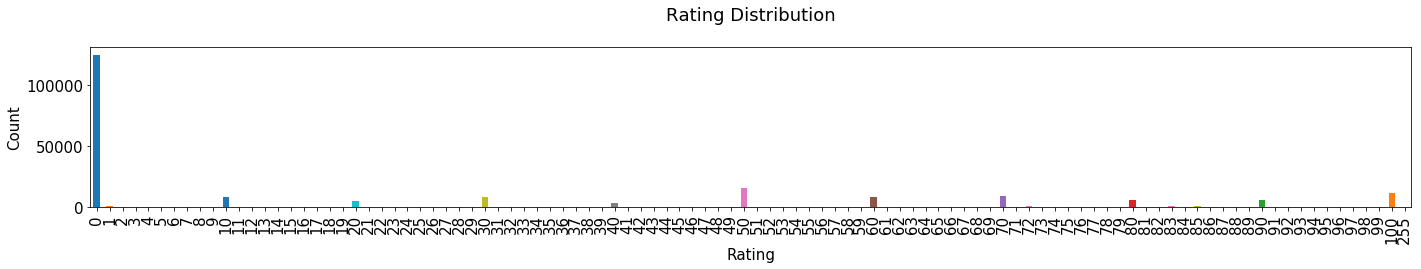

In [104]:
plt.rc("font", size=15)
plt.figure(figsize=(20,4))
rating.Rating.value_counts(sort=False).plot(kind='bar')
plt.title('Rating Distribution\n')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig('data1.png')
plt.show()

In [105]:
rating_with_totalRatCount = rat.merge(artist_ratingCount, left_on='ArtistName', right_on='ArtistName')
rating_with_totalRatCount.head()

,user_id,ArtistID,Rating,ArtistName,totalRatingCount
0,1,1000026,90,112,89
1,4,1000026,90,112,89
2,6,1000026,0,112,89
3,7,1000026,0,112,89
4,10,1000026,50,112,89


In [106]:
pd.set_option('display.float_format', lambda x: '%.3f' %x)
print(artist_ratingCount['totalRatingCount'].describe())

count   15837.000
mean       14.486
std        25.419
min         1.000
25%         1.000
50%         4.000
75%        17.000
max       190.000
Name: totalRatingCount, dtype: float64


In [107]:
print(artist_ratingCount['totalRatingCount'].quantile(np.arange(0.9,1,0.01))),

0.900    38.000
0.910    41.000
0.920    45.000
0.930    50.000
0.940    56.000
0.950    65.000
0.960    75.000
0.970    89.000
0.980   109.000
0.990   138.000
Name: totalRatingCount, dtype: float64


(None,)

In [108]:
pop_threshold = 138
rating_popular_artist = rating_with_totalRatCount.query('totalRatingCount >= @pop_threshold')
rating_popular_artist.head()

,user_id,ArtistID,Rating,ArtistName,totalRatingCount
281,1,1000264,50,A.F.I.,140
282,2,1000264,60,A.F.I.,140
283,3,1000264,0,A.F.I.,140
284,4,1000264,90,A.F.I.,140
285,6,1000264,30,A.F.I.,140


In [109]:
alpha_artist = rating_popular_artist[rating_popular_artist['ArtistName'].str.contains("a|e|i|o|u|y|A|E|I|O|U|Y")]
alpha_artist.head()

,user_id,ArtistID,Rating,ArtistName,totalRatingCount
281,1,1000264,50,A.F.I.,140
282,2,1000264,60,A.F.I.,140
283,3,1000264,0,A.F.I.,140
284,4,1000264,90,A.F.I.,140
285,6,1000264,30,A.F.I.,140


In [110]:
list(rating_popular_artist)
rating_pivot = rating_popular_artist.pivot_table(index = 'ArtistName', columns='user_id', values='Rating').fillna(0)
rating_pivot.head()
rating_matrix = csr_matrix(rating_pivot.values)

In [111]:
from sklearn.neighbors import NearestNeighbors

model_knn = NearestNeighbors(metric='cosine', algorithm='brute')
model_knn.fit(rating_matrix)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
         metric_params=None, n_jobs=1, n_neighbors=5, p=2, radius=1.0)

In [112]:
list_query_index = []
for i in range (0, rating_pivot.shape[0]):
    list_query_index.append(i)
    
dict_analysis = dict()

for j in list_query_index:

    query_index = j #np.random.choice(rating_pivot.shape[0])
    distances, indices = model_knn.kneighbors(rating_pivot.iloc[query_index,:].values.reshape(1,-1), n_neighbors=4)

    for i in range (0, len(distances.flatten())):
        if i ==0:
            print()
            print('Recommendations for {0}:\n'.format(rating_pivot.index[query_index]))
            dict_analysis[rating_pivot.index[query_index]]=[]
        else:
            print('{0}: {1}, with distance of {2}:'.format(i, rating_pivot.index[indices.flatten()[i]], distances.flatten()[i]))
            dict_analysis[rating_pivot.index[query_index]].append(rating_pivot.index[indices.flatten()[i]])


Recommendations for 3 Doors Down:

1: Creed, with distance of 0.24439299348841081:
2: Staind, with distance of 0.25050298587896125:
3: Nickelback, with distance of 0.25104854086513095:

Recommendations for 50 Cent:

1: Dr. Dre, with distance of 0.22565693443411694:
2: Ludacris, with distance of 0.23818076882166472:
3: Jay-Z, with distance of 0.23958589005511122:

Recommendations for A.F.I.:

1: The Ataris, with distance of 0.258322440419379:
2: Green Day, with distance of 0.2624848453706464:
3: Incubus, with distance of 0.2648613741558262:

Recommendations for AC/DC:

1: Guns N' Roses, with distance of 0.23229377527304784:
2: Led Zeppelin, with distance of 0.23764602315219385:
3: Green Day, with distance of 0.261014793128162:

Recommendations for Aaliyah:

1: Missy Elliott, with distance of 0.17589474509395653:
2: Mariah Carey, with distance of 0.24295766595358037:
3: Brandy, with distance of 0.247161137102192:

Recommendations for Aerosmith:

1: Green Day, with distance of 0.22130774


Recommendations for Prince:

1: Madonna, with distance of 0.20765190113490817:
2: Michael Jackson, with distance of 0.29652019260187135:
3: Sade, with distance of 0.3103949258300408:

Recommendations for Puddle Of Mudd:

1: Linkin Park, with distance of 0.2181666930034265:
2: Staind, with distance of 0.23100929880339305:
3: Papa Roach, with distance of 0.25384657608303807:

Recommendations for Queen:

1: Eric Clapton, with distance of 0.2732047242263338:
2: R.E.M., with distance of 0.28266581789041156:
3: U2, with distance of 0.28423094672404015:

Recommendations for R.E.M.:

1: Foo Fighters, with distance of 0.18899560621225897:
2: U2, with distance of 0.1976383117586693:
3: Green Day, with distance of 0.202060589130021:

Recommendations for Radiohead:

1: The White Stripes, with distance of 0.1924180905094679:
2: Jane's Addiction, with distance of 0.21046892788963123:
3: The Strokes, with distance of 0.22506162936104057:

Recommendations for Rage Against The Machine:

1: Jane's Addi

In [113]:
#print(dict_analysis)
numTotReco=0
num_cor=0
accur=0
total_reco = len(dict_analysis.keys())
#print(total_reco)
for j in dict_analysis.keys():
    numTotReco += len(dict_analysis[j])
    genre = label_genre(j)
    #print("Artist ", j)
    num=0
    for k in dict_analysis[j]:
        #print("Reco :",k)
        next_genre = label_genre(k)
        if genre == next_genre:
            num_cor+=1
            num+=1
        if genre != next_genre:
            orig_cor-=1
        if num >= 1:
            accur+=1
            
print("Accuracy of the kNN algorithm is: ", (accur/numTotReco)*100, "%")

Accuracy of the kNN algorithm is:  66.87370600414079 %


In [114]:
rating_pivot2 = rating_popular_artist.pivot_table(index = 'user_id', columns='ArtistName', values='Rating').fillna(0)
rating_pivot2.head()

ArtistName,3 Doors Down,50 Cent,A.F.I.,AC/DC,Aaliyah,Aerosmith,Alanis Morissette,Alien Ant Farm,Ashanti,Audioslave,...,Toby Keith,Tom Petty,Tori Amos,Trapt,Tupac Shakur,U2,Van Halen,Van Morrison,Weezer,ZZ Top
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.000,100.000,50.000,0.000,45.000,0.000,20.000,0.000,1.000,0.000,...,0.000,0.000,0.000,95.000,100.000,0.000,0.000,0.000,0.000,0.000
2,50.000,50.000,60.000,50.000,0.000,90.000,90.000,50.000,0.000,80.000,...,80.000,0.000,50.000,80.000,50.000,60.000,0.000,0.000,70.000,0.000
3,20.000,0.000,0.000,30.000,0.000,40.000,0.000,0.000,0.000,0.000,...,0.000,10.000,0.000,0.000,0.000,90.000,30.000,0.000,0.000,0.000
4,100.000,0.000,90.000,90.000,100.000,100.000,100.000,100.000,100.000,100.000,...,0.000,0.000,100.000,100.000,100.000,100.000,90.000,0.000,100.000,0.000
5,60.000,0.000,0.000,100.000,0.000,90.000,0.000,0.000,0.000,0.000,...,90.000,90.000,0.000,0.000,0.000,90.000,90.000,50.000,0.000,100.000


In [115]:
rating_pivot2.shape

(200, 161)

In [116]:
X = rating_pivot2.values.T
X.shape

(161, 200)

In [117]:
import sklearn
from sklearn.decomposition import TruncatedSVD

SVD = TruncatedSVD(n_components=15, random_state=17)
matrix = SVD.fit_transform(X)
matrix.shape

(161, 15)

In [118]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
corr = np.corrcoef(matrix)
corr.shape

(161, 161)

In [119]:
from collections import defaultdict
artist_titles = rating_pivot2.columns
artist_titles_list = list(artist_titles)

artists = ['3 Doors Down', '50 Cent', 'A.F.I.', 'AC/DC', 'Aaliyah', 'Aerosmith', 'Alanis Morissette', 
           'Alien Ant Farm', 'Ashanti', 'Audioslave', 'Avril Lavigne', 'Barenaked Ladies', 'Billy Joel', 
           'Bjork', 'Black Sabbath', 'Blink 182', 'Bob Marley', 'Bon Jovi', 'Boyz II Men', 'Brandy', 
           'Bush', 'Busta Rhymes', 'Chicago', 'Christina Aguilera', 'Coldplay', 'Collective Soul', 
           'Counting Crows', 'Creed', 'Creedence Clearwater Revival', 'DMX', 'Dave Matthews Band', 
           'Def Leppard', 'Deftones', 'Depeche Mode', "Destiny's Child", 'Dire Straits', 'Disturbed', 
           'Dr. Dre', 'Drowning Pool', 'Eagles', 'Elton John', 'Eminem', 'Enya', 'Eric Clapton', 
           'Evanescence', 'Fabolous', 'Faith Hill', 'Fleetwood Mac', 'Foo Fighters', 'Foreigner', 
           'Godsmack', 'Goo Goo Dolls', 'Good Charlotte', 'Green Day', "Guns N' Roses", 'INXS', 
           'Incubus', 'Ja Rule', 'James Taylor', "Jane's Addiction", 'Janet Jackson', 'Jason Mraz', 
           'Jay-Z', 'Jeff Foxworthy', 'Jennifer Lopez', 'Jewel', 'Jimi Hendrix', 'Jimmy Eat World', 
           'John Mayer', 'Journey', 'Kid Rock', 'Korn', 'LeAnn Rimes', 'Led Zeppelin', 'Lifehouse', 
           "Lil' Kim", 'Limp Bizkit', 'Linkin Park', 'Ludacris', 'Lynyrd Skynyrd', 'Madonna', 
           'Mariah Carey', 'Matchbox Twenty', 'Metallica', 'Michael Jackson', 'Michelle Branch', 
           'Missy Elliott', 'Moby', 'Motley Crue', 'Nelly', 'Nelly Furtado', 'New Order', 
           'Nickelback', 'Nine Inch Nails', 'Nirvana', 'No Doubt', 'Norah Jones', 'Oasis', 
           'Ozzy Osbourne', 'P.O.D.', 'Papa Roach', 'Paul Simon', 'Pearl Jam', 'Phil Collins', 
           'Pink', 'Pink Floyd', 'Powerman 5000', 'Prince', 'Puddle Of Mudd', 'Queen', 'R.E.M.', 
           'Radiohead', 'Rage Against The Machine', 'Rancid', 'Red Hot Chili Peppers', 'Sade', 
           'Sarah McLachlan', 'Sean Paul', 'Shakira', 'Shania Twain', 'Sheryl Crow', 'Simon & Garfunkel', 
           'Simple Plan', 'Sixpence None The Richer', 'Smashing Pumpkins', 'Staind', 'Static-X', 
           'Sting', 'Stone Temple Pilots', 'Sublime', 'Sugar Ray', 'Sum 41', 'System Of A Down', 
           'Taking Back Sunday', 'The All-American Rejects', 'The Ataris', 'The Cars', 'The Corrs', 
           'The Cure', 'The Doors', 'The Offspring', 'The Police', 'The Prodigy', 'The Ramones', 
           'The Rolling Stones', 'The Smiths', 'The Strokes', 'The Used', 'The White Stripes', 
           'Third Eye Blind', 'Tim McGraw', 'Toby Keith', 'Tom Petty', 'Tori Amos', 'Trapt', 
           'Tupac Shakur', 'U2', 'Van Halen', 'Van Morrison', 'Weezer', 'ZZ Top']

dict_analysis = defaultdict(list)
for i in artists:
    art = artist_titles_list.index(i)
    corr_artist = corr[art]
    print("Recommendations for ", i, "are: ", list(artist_titles[(corr_artist<1.0) & (corr_artist>0.9)]))
    dict_analysis[i]=list(artist_titles[(corr_artist<1.0) & (corr_artist>0.9)])
    

Recommendations for  3 Doors Down are:  ['3 Doors Down', 'Collective Soul', 'Creed', 'Goo Goo Dolls', 'Nickelback', 'Staind', 'Toby Keith']
Recommendations for  50 Cent are:  ['DMX', 'Dr. Dre', 'Eminem', 'Ja Rule', 'Jay-Z', "Lil' Kim", 'Ludacris', 'Missy Elliott', 'Nelly', 'Tupac Shakur']
Recommendations for  A.F.I. are:  ['The All-American Rejects']
Recommendations for  AC/DC are:  ["Guns N' Roses", 'Metallica']
Recommendations for  Aaliyah are:  ['Aaliyah', 'Boyz II Men', "Lil' Kim", 'Mariah Carey', 'Missy Elliott', 'Nelly', 'Sean Paul', 'Shakira']
Recommendations for  Aerosmith are:  ['Aerosmith', 'Counting Crows', 'Goo Goo Dolls', 'Green Day', "Guns N' Roses", 'Matchbox Twenty', 'Queen', 'Sheryl Crow']
Recommendations for  Alanis Morissette are:  ['Barenaked Ladies', 'Enya', 'Goo Goo Dolls', 'Jewel', 'Lifehouse', 'Michelle Branch', 'No Doubt', 'Sheryl Crow', 'Sixpence None The Richer', 'Sugar Ray', 'The Corrs']
Recommendations for  Alien Ant Farm are:  ['Audioslave', 'Blink 182', '

In [120]:
def label_genre (at):
    if at == '3 Doors Down' or at == 'A.F.I.' or at == 'AC/DC' or at == 'Aerosmith' or at == 'Alanis Morissette' or at == 'Alien Ant Farm' or at == 'Audioslave' or at == 'Avril Lavigne' or at == 'Barenaked Ladies' or at == 'Blink 182' or at == 'Bon Jovi' or at == 'Bush' or at == 'Chicago' or at == 'Coldplay' or at == 'Collective Soul' or at == 'Counting Crows' or at == 'Creedence Clearwater Revival' or at == 'Dave Matthews Bank' or at == 'Dire Straits' or at == 'Eagles' or at == 'Eric Clapton' or at == 'Fleetwood Mac' or at == 'Foo Fighters' or at == 'Foreigner' or at == 'Goo Goo Dolls' or at == 'Good Charlotte' or at == 'Green Day' or at == "Guns N' Roses" or at == 'INXS' or at == 'Incubus' or at == 'James Taylor' or at == 'Jimi Hendrix' or at == 'Jimmy Eat World' or at == 'Journey' or at == 'Led Zeppelin' or at == 'Lifehouse' or at == 'Linkin Park' or at == 'Lynyrd Skynyrd' or at == 'Matchbox Twenty' or at == 'Nickelback' or at == 'Nine Inch Nails' or at == 'Nirvana' or at == 'Oasis' or at == 'Pearl Jam' or at == 'Pink Floyd' or at == 'Queen' or at == 'R.E.M.' or at == 'Radiohead' or at == 'Rancid' or at == 'Red Hot Chili Peppers' or at == 'Simon & Garfunkel' or at == 'Simple Plan' or at == 'Sixpence None The Richer' or at == 'Smashing Pumpkins' or at == 'Sting'  or at == 'Stone Temple Pilots' or at == 'Sublime' or at == 'Sugar Ray' or at == 'Sum 41' or at == 'Taking Back Sunday' or at == 'The All-American Rejects' or at == 'The Cars' or at == 'The Corrs' or at == 'The Cure' or at == 'The Doors' or at == 'The Rolling Stones' or at == 'The Smiths' or at == 'The Strokes' or at == 'The White Stripes' or at == 'Third Eye Blind' or at == 'Tom Petty' or at == 'Tori Amos' or at == 'Trapt' or at == 'U2' or at == 'Van Halen' or at == 'Van Morrison' or at == 'ZZ Top':
        return 'Rock'
    if at == 'Aaliyah' or at == 'Ashanti' or at == 'Boyz II Men' or at == "Destiny's Child" or at == 'Nelly Furtado':
        return 'R&B'
    if at == '50 Cent' or at == 'Eminem' or at == 'Jay-Z' or at == "Lil' Kim" or at == 'Limp Bizkit' or at == 'Ludacris' or at == 'Tupac Shakur':
        return 'Rap'
    if at == 'Billy Joel':
        return 'Alternative'
    if at == 'Weezer' or at == 'The Used' or at == 'The Ramones' or at == 'The Offspring' or at == 'The Police' or at == 'The Ataris' or at == 'No Doubt' or at == 'Moby':
        return 'Punk'
    if at == 'Black Sabbath' or at == 'Creed' or at == 'Def Leppard' or at == 'Deftones' or at == 'Disturbed' or at == 'Drowning Pool' or at == 'Evanescence' or at == 'Godsmack' or at == "Jane's Addiction" or at == 'Korn' or at == 'Metallica' or at == 'Motley Crue' or at == 'Ozzy Osbourne' or at == 'P.O.D.' or at == 'Papa Roach' or at == 'Powerman 5000' or at == 'Puddle Of Mudd' or at == 'Rage Against The Machine' or at == 'Staind' or at == 'Static-X' or at == 'System Of A Down':
        return 'Metal'
    if at == 'Busta Rhymes' or at == 'DMX' or at == 'Dr. Dre' or at == 'Fabolous' or at == 'Ja Rule' or at == 'Missy Elliott' or at == 'Nelly' or at == 'Sean Paul':
        return 'Hip Hop'
    if at == 'Brandy' or at == 'Christina Aguilera' or at == 'Depeche Mode' or at == 'Elton John' or at == 'Enya' or at == 'Janet Jackson' or at == 'Jennifer Lopez' or at == 'Jewel' or at == 'Madonna' or at == 'Mariah Carey' or at == 'Michael Jackson' or at == 'Michelle Branch' or at == 'New Order' or at == 'Paul Simon' or at == 'Phil Collins' or at == 'Pink' or at == 'Prince' or at == 'Sade' or at == 'Sarah McLachlan' or at == 'Shakira' or at == 'Sheryl Crow':
        return 'Pop'
    if at == 'Bjork':
        return 'Experimental'
    if at == 'Bob Marley':
        return 'Reggae'
    if at == 'Faith Hill' or at == 'Kid Rock' or at == 'LeAnn Rimes' or at == 'Shania Twain' or at == 'Tim McGraw' or at == 'Toby Keith':
        return 'Country'
    if at == 'The Prodigy':
        return 'Electronic'
    if at == 'Norah Jones' or at == 'John Mayer' or at == 'Jason Mraz':
        return 'Blue'
    if at == 'Jeff Foxworthy':
        return 'Comedy'
    return 'Other'

In [121]:
numTotReco=0
num_cor=0
orig_cor=1000
accur=0
total_reco = len(dict_analysis.keys())
#print(total_reco)
for j in dict_analysis.keys():
    numTotReco += len(dict_analysis[j])
    genre = label_genre(j)
    #print("Artist ", j)
    num=0
    for k in dict_analysis[j]:
        #print("Reco :",k)
        next_genre = label_genre(k)
        if genre == next_genre:
            num_cor+=1
            num+=1
        if genre != next_genre:
            orig_cor-=1
        if num >= 1:
            accur+=1
            
print("Accuracy of the SVD algorithm is: ", (accur/numTotReco)*100, "%")
# print(numTotReco)
# print(num_cor)
# print(orig_cor)
# x=dict()
# x['Artist Name'] = 'henty'
# print(x)
# x['Artist Name'] = 'benty'
# print(x)

Accuracy of the SVD algorithm is:  80.9 %


In [ ]:
#https://towardsdatascience.com/how-did-we-build-book-recommender-systems-in-an-hour-part-2-k-nearest-neighbors-and-matrix-c04b3c2ef55c